Article: [Telco Customer Churn with R in SQL Server 2016](http://blog.revolutionanalytics.com/2016/08/telco-customer-churn-with-r-in-sql-server-2016.html)

[MS SQL Server R Services samples](https://github.com/Microsoft/sql-server-samples/tree/master/samples/features/r-services/telco-customer-churn-v1)

[H2O version](https://github.com/WLOGSolutions/telco-customer-churn-in-r-and-h2o)

# Текст задания для кандидата

Необходимо построить модель прогнозирования оттока клиентов по имеющимся признакам (колонка churn в файле – целевая переменная), кратко в формате письма описать методику подготовки данных, построения модели и оценки качества полученной модели. Результат может быть представлен, например, в виде http://jupyter.org/ ноутбука с кодом.
Я готов ответить на любые вопросы по заданию. Данные находятся в приложенном файле.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [4]:
df = pd.read_csv('mssql-r-samples-telco-customer-churn-v1.csv')

In [4]:
df[:3].T

,0,1,2
age,12,12,42
annualincome,168147,168147,29047
calldroprate,0.06,0.06,0.05
callfailurerate,0,0,0.01
callingnum,4251078442,4251078442,4251043419
customerid,1,1,2
customersuspended,Yes,Yes,Yes
education,Bachelor or equivalent,Bachelor or equivalent,Bachelor or equivalent
gender,Male,Male,Female
homeowner,Yes,Yes,Yes


In [6]:
uniq_vals = df.apply(pd.Series.nunique)
uniq_vals

age                                       68
annualincome                            9508
calldroprate                               8
callfailurerate                            4
callingnum                              9525
customerid                              9525
customersuspended                          2
education                                  4
gender                                     2
homeowner                                  2
maritalstatus                              2
monthlybilledamount                      120
noadditionallines                          1
numberofcomplaints                         4
numberofmonthunpaid                        8
numdayscontractequipmentplanexpiring     100
occupation                                 3
penaltytoswitch                          500
state                                     50
totalminsusedinlastmonth                 500
unpaidbalance                            250
usesinternetservice                        2
usesvoices

In [5]:
df.churn.value_counts()

0    18605
1     1863
Name: churn, dtype: int64

In [22]:
df.groupby('customerid').customerid.count().value_counts()

2    7917
3    1513
1      95
Name: customerid, dtype: int64

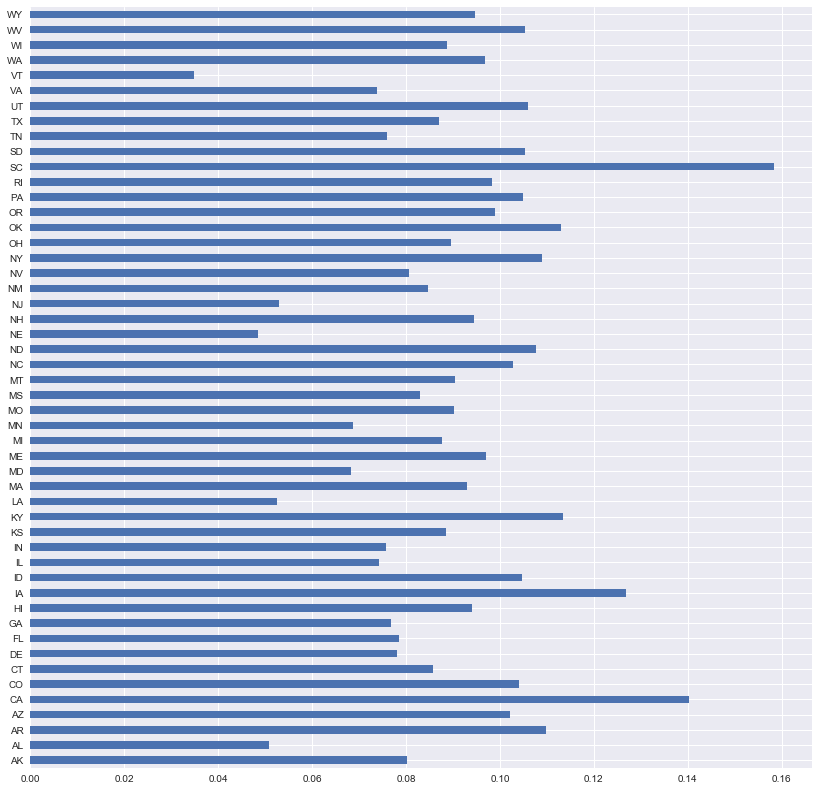

In [4]:
churn_share = (df[df.churn==1].state.value_counts() / df.state.value_counts())
churn_share.plot(kind='barh', figsize=(14, 14))

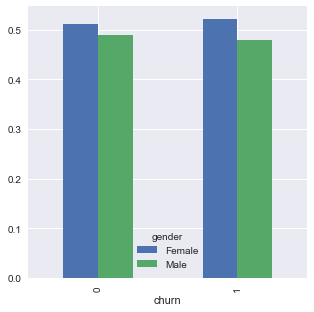

In [94]:
ct = pd.crosstab(df.churn, df.gender)
(ct.T / ct.T.sum()).T.plot.bar(figsize=(5, 5))

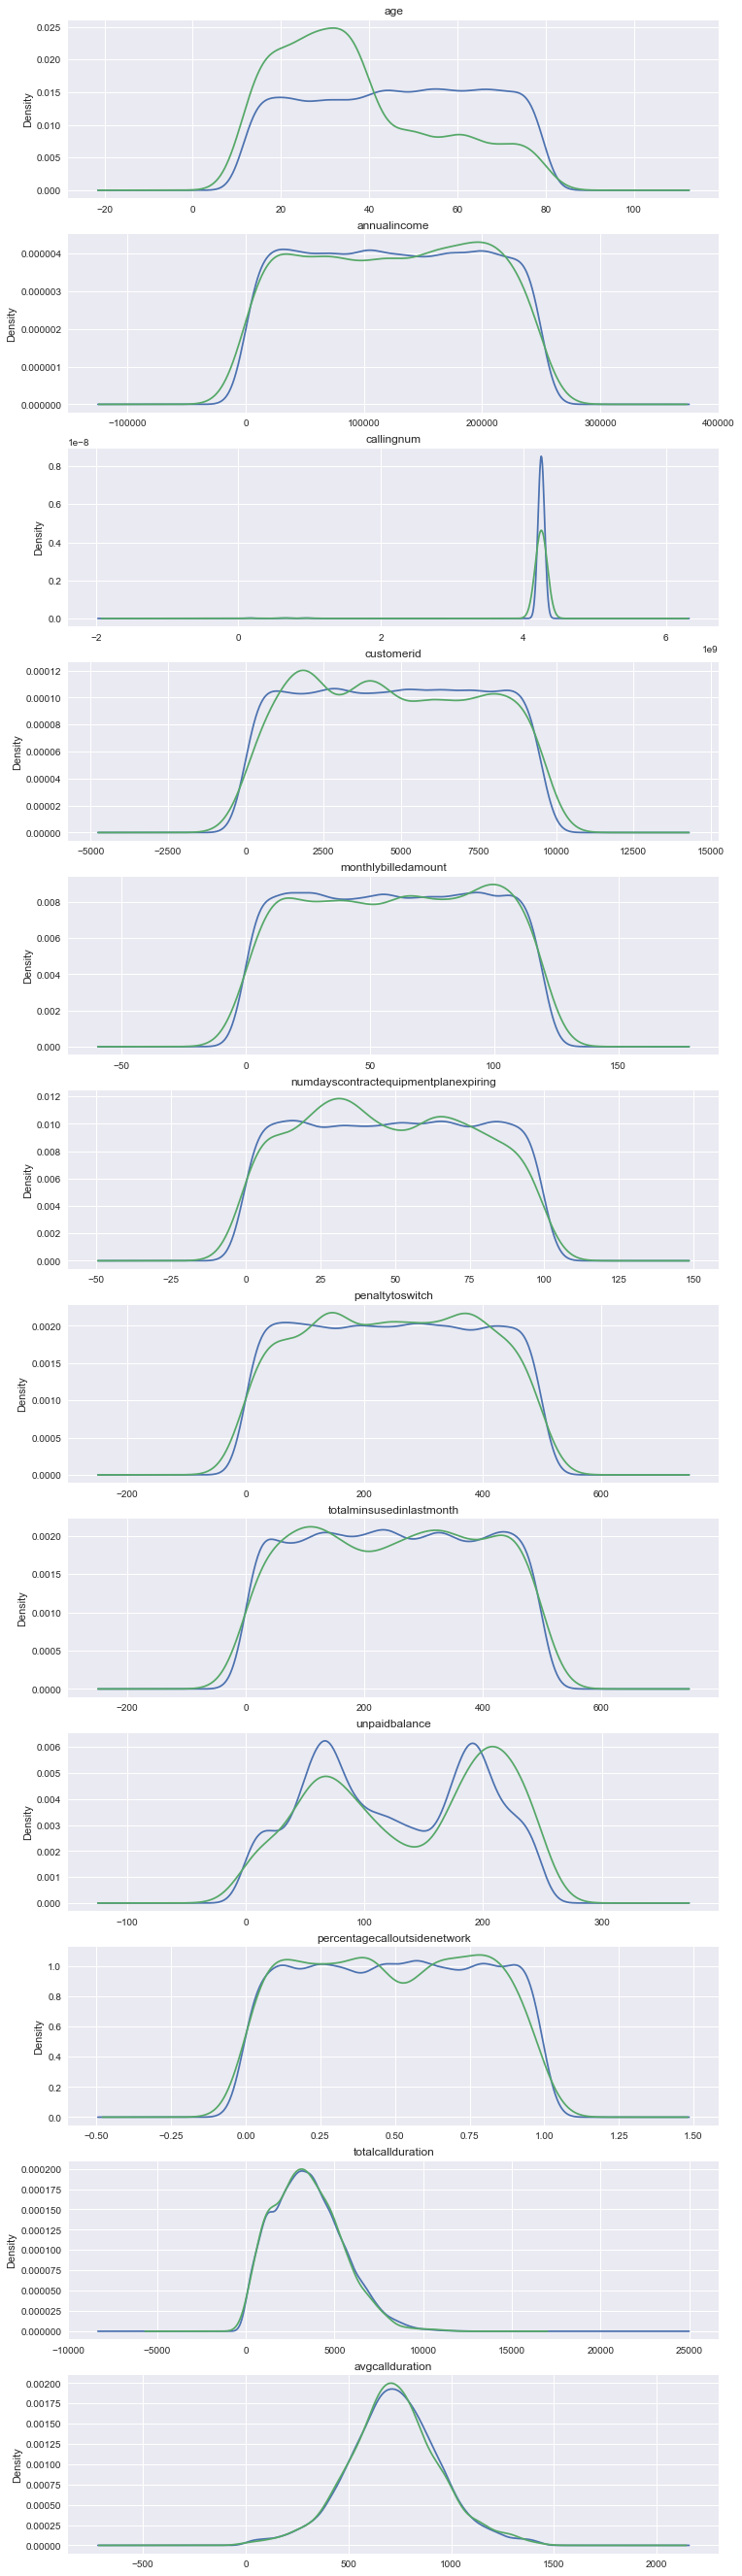

In [17]:
cols = [col for col in df.select_dtypes(include=[np.number]).columns if df[col].nunique() > 10]
plt.figure(1, (12, len(cols)*4))
for i, col in enumerate(cols):
    plt.subplot(len(cols), 1, i+1)
    df.groupby('churn')[col].plot(kind='kde', title=col)

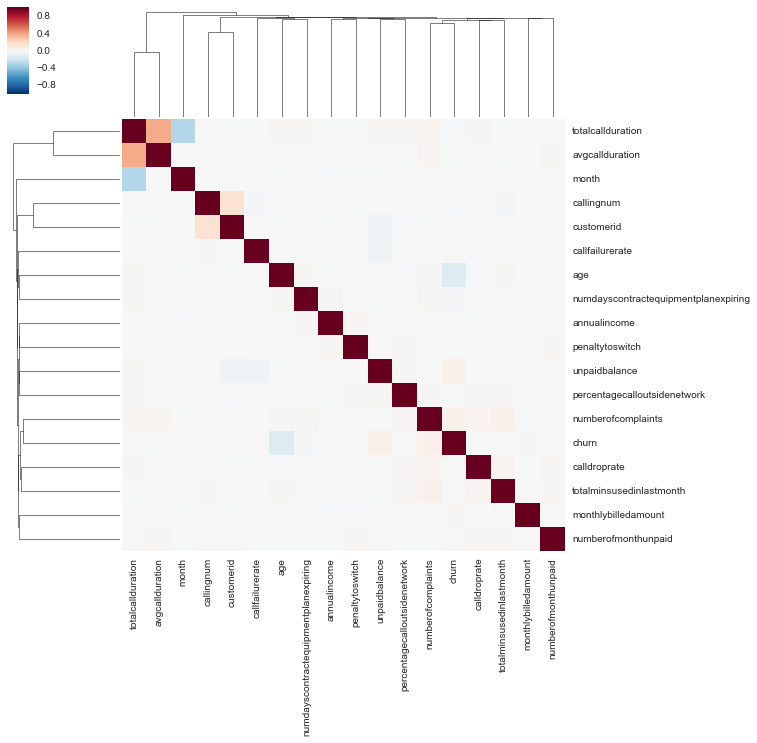

In [9]:
cm = df.drop('year', axis=1).corr()
cmap = sns.clustermap(cm)
plt.setp(cmap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
None

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

cl = RandomForestClassifier(n_estimators = 300, class_weight = 'balanced')

features = pd.get_dummies(df.drop(['churn', 'callingnum', 'customerid'], axis=1))
target = df.churn

# Duplicate samples in train and test
kf = StratifiedKFold(n_splits=3, shuffle=True)
cv = cross_val_score(cl, features, target, cv=kf, scoring='roc_auc')
cv.mean(), cv.std()

(0.95459708487990047, 0.0037134960633064098)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

cl = RandomForestClassifier(n_estimators = 300, class_weight = 'balanced')

features = pd.get_dummies(df.drop(['churn', 'callingnum', 'customerid'], axis=1))
target = df.churn

# No duplicate samples in train and test
# due to usage of StratifiedKFold with shuffle=False (default value of shuffle arg)
# shuffle=False is the default value of shuffle arg
# this is the default value of cv arg for cross_val_score
kf = StratifiedKFold(n_splits=3, shuffle=False)
cv = cross_val_score(cl, features, target, cv=kf, scoring='roc_auc')
cv.mean(), cv.std()

(0.7069279958011033, 0.00816902710690289)